In [2]:
import torch
from utils.dataset_utils import load_dataset, load_dataset_with_pairs
from tda.compute import analyze_and_plot_tda
# json_file = "/home/muzammal/Projects/safe_proj/long_safe_clip/dataset/visu/ViSU-Text_test.json"
# safe_img_dir = "/home/muzammal/Projects/safe_proj/long_safe_clip/dataset/visu/image/test_coco"
# nsfw_image_dir = "/home/muzammal/Projects/safe_proj/long_safe_clip/dataset/visu/image/test_nsfw_flux_sldr"
json_file = "/home/muzammal/Projects/safe_proj/safe_tda/data/dataset/ViSU-Text_test.json"
safe_img_dir = "/home/muzammal/Projects/safe_proj/safe_tda/data/dataset/test_coco"
nsfw_image_dir = "/home/muzammal/Projects/safe_proj/safe_tda/data/dataset/test_FLUX_Unsensored"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
# Load data
print("Loading dataset...")
safe_texts, safe_image_paths, nsfw_texts, nsfw_image_paths = load_dataset(json_file, safe_img_dir, nsfw_image_dir)
# Load paired data for NSFW evaluations
# print("Loading paired dataset...")
# pairs, all_texts, all_image_paths = load_dataset_with_pairs(json_file, safe_img_dir, nsfw_image_dir)

Using device: cuda
Loading dataset...
Loading dataset...
Loaded 5000 safe texts and 5000 NSFW texts
Loaded 5000 safe images and 5000 NSFW images


In [4]:
from utils.dataset_utils import extract_text_embeddings, extract_image_embeddings
from utils.model_utils import load_clip
model_name = "ViT-L/14"  # or "longclip"
device = "cuda:0" if torch.cuda.is_available() else "cpu"
clip_model, clip_preprocess, clip_tokenizer = load_clip(model_name, device)
print("-" * 30)
safe_text_embeddings = extract_text_embeddings(safe_texts, clip_model, clip_tokenizer, device, batch_size=128)
nsfw_text_embeddings = extract_text_embeddings(nsfw_texts, clip_model, clip_tokenizer, device, batch_size=128)
# safe_image_embeddings = extract_image_embeddings(safe_image_paths, clip_model, clip_preprocess, device, batch_size=64)
# nsfw_image_embeddings = extract_image_embeddings(nsfw_image_paths, clip_model, clip_preprocess, device, batch_size=64)

Loading CLIP model...
------------------------------
Extracting TEXT embeddings...


Extracting text features: 100%|██████████| 40/40 [00:03<00:00, 10.83it/s]


text_features shape: torch.Size([5000, 768])
Extracting TEXT embeddings...


Extracting text features: 100%|██████████| 40/40 [00:03<00:00, 11.31it/s]

text_features shape: torch.Size([5000, 768])


/home/muzammal/Projects/safe_proj/safe_tda/tda/compute.py:35: UserWarning: Falling back to manual Betti computation from persistence intervals.
  warnings.warn("Falling back to manual Betti computation from persistence intervals.", UserWarning)
/home/muzammal/miniconda3/envs/flux/lib/python3.12/site-packages/gudhi/persistence_graphical_tools.py:129: UserWarning: usetex mode requires TeX.
  warnings.warn("usetex mode requires TeX.")


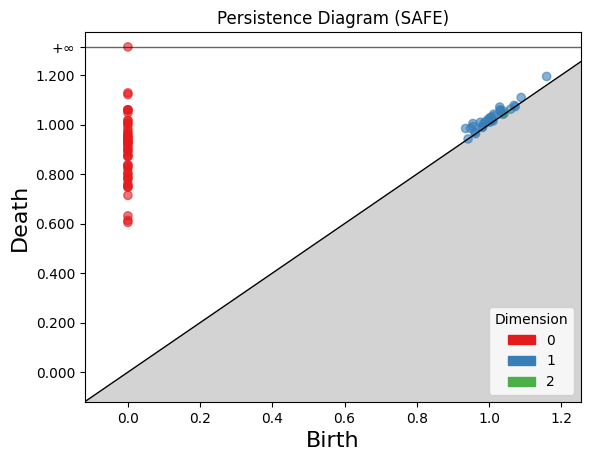

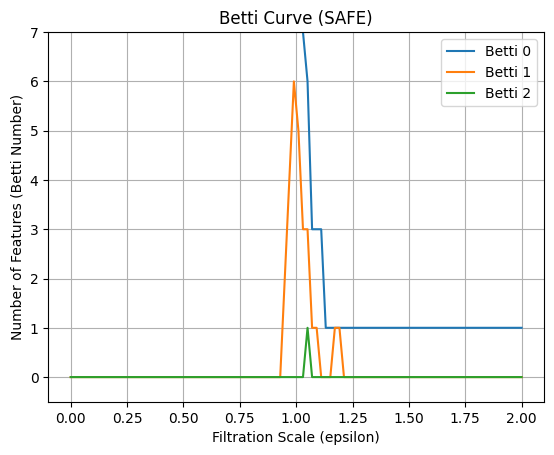

/home/muzammal/Projects/safe_proj/safe_tda/tda/compute.py:35: UserWarning: Falling back to manual Betti computation from persistence intervals.
  warnings.warn("Falling back to manual Betti computation from persistence intervals.", UserWarning)


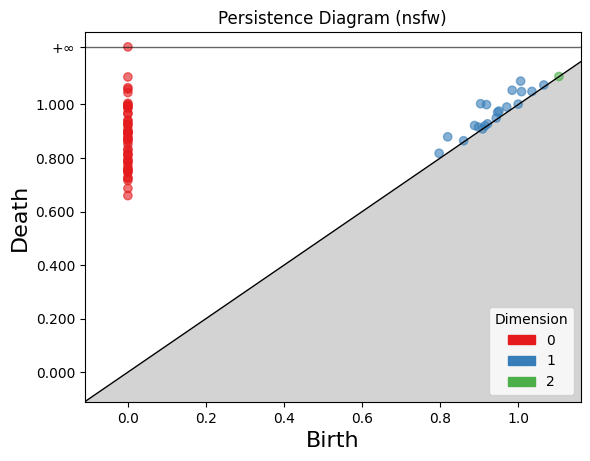

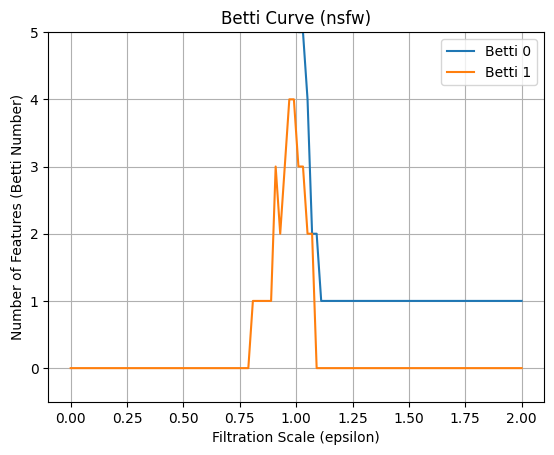

In [5]:
x = 1100
persistence_safe, betti_safe, thresholds = analyze_and_plot_tda(safe_text_embeddings[x:x+50], f"SAFE",complex='rips',max_filt_scale=2,max_hom_dim=3,threshold_count=100, plot=True)
persistence_nsfw, betti_nsfw, thresholds = analyze_and_plot_tda(nsfw_text_embeddings[x:x+50], f"nsfw",complex='rips',max_filt_scale=2,max_hom_dim=3,threshold_count=100, plot=True)

In [6]:
import numpy as np
import warnings
import gudhi as gd
import matplotlib.pyplot as plt

def vectorize_persistence_image(
        persistence_intervals,
        target_dim: int = 1,
        bandwidth: float = 0.3,
        resolution: tuple = (20, 20),
        im_range: list = None,
        normalize: bool = False,
        plot: bool = True
    ) -> np.ndarray:
    # 1. 收集 finite interval
    diagrams_by_dim = {}
    for dim, (b, d) in persistence_intervals:
        if not np.isinf(d):
            diagrams_by_dim.setdefault(dim, []).append([b, d])

    # 2. 如果没有这一维，返回全零
    if target_dim not in diagrams_by_dim or len(diagrams_by_dim[target_dim]) == 0:
        warnings.warn(f"No finite intervals for dimension {target_dim}")
        return np.zeros(resolution[0] * resolution[1])

    # 3. 转成 array
    diagram = np.array(diagrams_by_dim[target_dim])  # shape (N,2)
    births = diagram[:, 0]
    persistences = diagram[:, 1] - diagram[:, 0]

    # 4. 自动估算 im_range
    if im_range is None:
        b_min, b_max = births.min(), births.max()
        p_min, p_max = persistences.min(), persistences.max()
        pad_b = (b_max - b_min) * 0.05 if b_max > b_min else 0.1
        pad_p = (p_max - p_min) * 0.05 if p_max > p_min else 0.1
        im_range = [
            max(0.0, b_min - pad_b),
            max(0.0, p_min - pad_p),
            b_max + pad_b,
            p_max + pad_p
        ]

    # 5. 构造 PersistenceImage
    PI = gd.representations.PersistenceImage(
        bandwidth=bandwidth,
        resolution=resolution,
        im_range=im_range
    )

    # 6. fit_transform
    image_vec = PI.fit_transform([diagram])[0]  # shape = (W*H,)

    # 7. 可选绘图
    if plot:
        W, H = resolution
        img = image_vec.reshape((W, H))
        plt.figure(figsize=(4, 4))
        plt.imshow(
            img.T, 
            origin='lower', 
            extent=[im_range[0], im_range[2], im_range[1], im_range[3]]
        )
        plt.title(f'Persistence Image (H{target_dim})')
        plt.xlabel('Birth')
        plt.ylabel('Persistence')
        plt.colorbar(label='Intensity')
        plt.tight_layout()
        plt.show()

    # 8. 归一化（可选）
    if normalize:
        m = image_vec.max()
        if m > 0:
            image_vec = image_vec / m

    return image_vec


In [7]:
def vectorize_landscape(persistence_intervals,
                        num_landscapes: int = 3,
                        resolution: int = 100,
                        x_min: float = 0.0,
                        x_max: float = 1.0,
                        plot: bool = True):
    # 过滤掉无穷大的死亡时间点，因为 Landscape 通常处理有限区间
    finite_intervals = [pair for pair in persistence_intervals if not np.isinf(pair[1][1])]
    if not finite_intervals:
        warnings.warn("No finite persistence intervals found for Landscape vectorization.")
        return np.zeros(num_landscapes * resolution)

    # 按 homology 维度分组
    diagrams_by_dim = {}
    for dim, (birth, death) in finite_intervals:
        diagrams_by_dim.setdefault(dim, []).append([birth, death])

    # 构建 GUDHI 接受的 diagram 列表
    max_dim = max(diagrams_by_dim.keys(), default=0)
    diagram_list = [
        np.array(diagrams_by_dim[d]) if d in diagrams_by_dim else np.empty((0, 2))
        for d in range(max_dim + 1)
    ]

    # 选择 H1 作为目标维度（通常信息量更丰富）
    target_dim = 1
    if target_dim >= len(diagram_list) or diagram_list[target_dim].shape[0] == 0:
        warnings.warn(f"No valid persistence intervals in dimension {target_dim}.")
        return np.zeros(num_landscapes * resolution)

    # 计算 Landscape
    LS = gd.representations.Landscape(
        num_landscapes=num_landscapes,
        resolution=resolution,
        sample_range=[x_min, x_max]
    )
    landscape_vec = LS.fit_transform([diagram_list[target_dim]])[0]

    # 可选绘图
    if plot:
        xs = np.linspace(x_min, x_max, resolution)
        # landscape_vec 是一个长度 = num_landscapes * resolution 的一维数组，
        # 重塑为 (num_landscapes, resolution)
        landscapes = landscape_vec.reshape(num_landscapes, resolution)
        plt.figure(figsize=(6, 4))
        for i, vec in enumerate(landscapes):
            plt.plot(xs, vec, label=f'Landscape {i+1}')
        plt.title(f'Persistence Landscapes (H{target_dim})')
        plt.xlabel('Filtration scale')
        plt.ylabel('Landscape value')
        plt.legend()
        plt.tight_layout()
        plt.show()

    return landscape_vec


--- Vectorizing Features ---


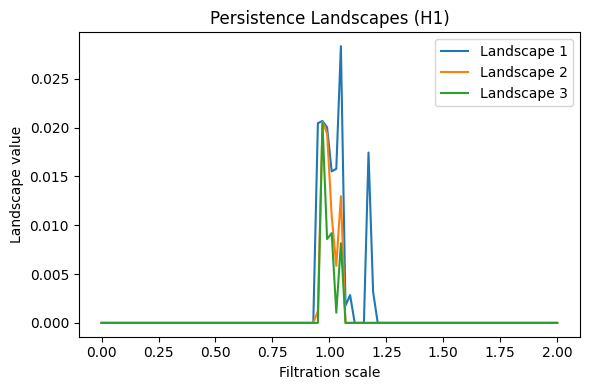

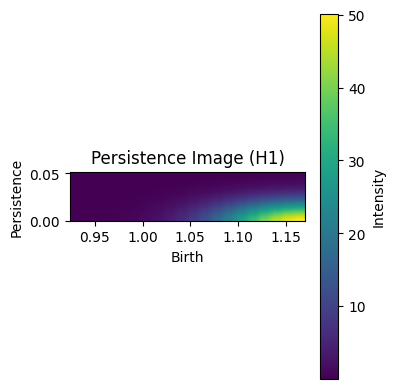

Safe Vector Lengths:
  Landscape (H1): (300,)
  Image (H1): (400,)
  Betti Curve: (150,)
  Simple Stats (H0, H1): (16,)


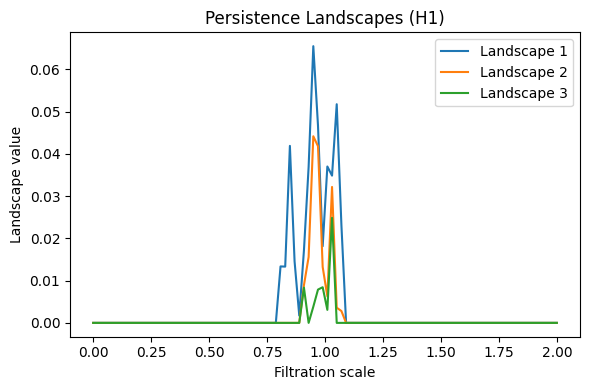

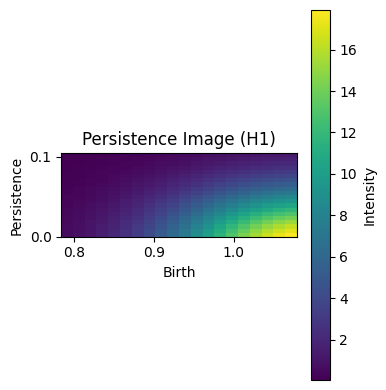


nsfw Vector Lengths:
  Landscape (H1): (300,)
  Image (H1): (400,)
  Betti Curve: (150,)
  Simple Stats (H0, H1): (24,)


In [8]:
from tda.vectorize import vectorize_betti_curve, vectorize_simple_stats
import numpy as np
print("\n--- Vectorizing Features ---")

MAX_FILTRATION_SCALE = 2.0  # Adjust this based on your data
# --- Safe Data ---
# Persistence Landscape (H1, 3 landscapes, 100 samples between scale 0 and 1.5)
landscape_vec_safe = vectorize_landscape(persistence_safe, num_landscapes=3, resolution=100, x_min=0.0, x_max=MAX_FILTRATION_SCALE) 
# Persistence Image (H1, default params, 20x20 resolution)
image_vec_safe = vectorize_persistence_image(persistence_safe, resolution=[20, 20]) 
# Betti Curve Vector (sampling at 50 points)
betti_vec_safe = vectorize_betti_curve(
    betti_data=betti_safe,
    thresholds=thresholds,
    num_samples=50,
    max_hom_dim=2  # Assuming we care about H0, H1, H2
)
# Simple Stats (H0, H1)
stats_vec_safe = vectorize_simple_stats(persistence_safe, max_dim=1) 

print("Safe Vector Lengths:")
print(f"  Landscape (H1): {landscape_vec_safe.shape}")
print(f"  Image (H1): {image_vec_safe.shape}")
print(f"  Betti Curve: {betti_vec_safe.shape}")
print(f"  Simple Stats (H0, H1): {stats_vec_safe.shape}")


# --- nsfw Data (similar calls) ---
landscape_vec_nsfw = vectorize_landscape(persistence_nsfw, num_landscapes=3, resolution=100, x_min=0.0, x_max=MAX_FILTRATION_SCALE)
image_vec_nsfw = vectorize_persistence_image(persistence_nsfw, bandwidth = 0.4, resolution=[20, 20])
betti_vec_nsfw = vectorize_betti_curve(
    betti_data=betti_nsfw,
    thresholds=thresholds,
    num_samples=50,
    max_hom_dim=2  # 假设我们关心 H0、H1、H2
)
stats_vec_nsfw = vectorize_simple_stats(persistence_nsfw, max_dim=2)

print("\nnsfw Vector Lengths:")
print(f"  Landscape (H1): {landscape_vec_nsfw.shape}")
print(f"  Image (H1): {image_vec_nsfw.shape}")
print(f"  Betti Curve: {betti_vec_nsfw.shape}")
print(f"  Simple Stats (H0, H1): {stats_vec_nsfw.shape}")

# --- Now you can use these vectors (e.g., landscape_vec_safe, image_vec_nsfw) ---
# --- as input features for machine learning models ---

In [10]:
betti_vec_safe, betti_vec_nsfw

(array([50,  0,  0, 50,  0,  0, 50,  0,  0, 50,  0,  0, 50,  0,  0, 50,  0,
         0, 50,  0,  0, 50,  0,  0, 50,  0,  0, 50,  0,  0, 50,  0,  0, 49,
         0,  0, 48,  0,  0, 48,  0,  0, 48,  0,  0, 48,  0,  0, 46,  0,  0,
        44,  0,  0, 41,  0,  0, 35,  0,  0, 26,  0,  0, 19,  2,  0,  9,  3,
         0,  2,  0,  0,  2,  0,  0,  2,  0,  0,  1,  0,  0,  1,  0,  0,  1,
         0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,
         1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,
         0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,
         0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0]),
 array([50,  0,  0, 50,  0,  0, 50,  0,  0, 50,  0,  0, 50,  0,  0, 50,  0,
         0, 50,  0,  0, 50,  0,  0, 50,  0,  0, 50,  0,  0, 50,  0,  0, 50,
         0,  0, 50,  0,  0, 50,  0,  0, 50,  0,  0, 50,  0,  0, 48,  0,  0,
        45,  0,  0, 41,  0,  0, 39,  0,  0, 31,  0,  0, 16,  3,  0,  7,  6,
         0,  4,  3,  0

In [11]:
image_vec_safe, image_vec_nsfw

(array([1.35119105e-01, 1.30399628e-01, 1.23218358e-01, 1.14001966e-01,
        1.03272695e-01, 9.15995490e-02, 7.95489130e-02, 6.76404834e-02,
        5.63130649e-02, 4.59029005e-02, 3.66351614e-02, 2.86273826e-02,
        2.19022780e-02, 1.64066393e-02, 1.20329268e-02, 8.64057914e-03,
        6.07481446e-03, 4.18158039e-03, 2.81814836e-03, 1.85952470e-03,
        2.25607254e-01, 2.17717012e-01, 2.05717538e-01, 1.90321691e-01,
        1.72401749e-01, 1.52907879e-01, 1.32785699e-01, 1.12902729e-01,
        9.39913163e-02, 7.66125074e-02, 6.11418792e-02, 4.77753179e-02,
        3.65504427e-02, 2.73781773e-02, 2.00788050e-02, 1.44175430e-02,
        1.01359246e-02, 6.97674549e-03, 4.70173865e-03, 3.10226513e-03,
        3.66634487e-01, 3.53795532e-01, 3.34280609e-01, 3.09248931e-01,
        2.80118504e-01, 2.48433618e-01, 2.15730888e-01, 1.83419769e-01,
        1.52689883e-01, 1.24452373e-01, 9.93169579e-02, 7.76013851e-02,
        5.93662929e-02, 4.44665423e-02, 3.26098170e-02, 2.341442

In [12]:
np.log1p(image_vec_safe), np.log1p(image_vec_nsfw)

(array([1.26737584e-01, 1.22571223e-01, 1.16198099e-01, 1.07958906e-01,
        9.82809397e-02, 8.76440967e-02, 7.65432808e-02, 6.54510578e-02,
        5.47846043e-02, 4.48805320e-02, 3.59800461e-02, 2.82252752e-02,
        2.16658689e-02, 1.62735046e-02, 1.19611067e-02, 8.60346298e-03,
        6.05643716e-03, 4.17286188e-03, 2.81418482e-03, 1.85779792e-03,
        2.03436439e-01, 1.96977804e-01, 1.87074857e-01, 1.74223600e-01,
        1.59054422e-01, 1.42287341e-01, 1.24679820e-01, 1.06971673e-01,
        8.98327664e-02, 7.38195445e-02, 5.93455728e-02, 4.66691716e-02,
        3.58983181e-02, 2.70100982e-02, 1.98798841e-02, 1.43145986e-02,
        1.00849006e-02, 6.95252061e-03, 4.69072001e-03, 3.09746303e-03,
        3.12351139e-01, 3.02912153e-01, 2.88392277e-01, 2.69453638e-01,
        2.46952655e-01, 2.21889660e-01, 1.95345450e-01, 1.68408356e-01,
        1.42098240e-01, 1.17296138e-01, 9.46890395e-02, 7.47376315e-02,
        5.76708925e-02, 4.35062692e-02, 3.20894005e-02, 2.314451

In [11]:

from tda.distance import compute_bottleneck_distance, compute_wasserstein_distance
# 设定要比较的维度 (例如 H1)
compare_dimension = 1

# 1. 计算瓶颈距离 (Bottleneck Distance)
# 使用近似算法（通常更快，e=None 或 e > 0）
approx_bottleneck_dist = compute_bottleneck_distance(
    persistence_safe, 
    persistence_nsfw, 
    dimension=compare_dimension, 
    e=None # 或者设为一个小的正数，如 0.01
)
# 或者计算精确距离 (可能非常慢)
# exact_bottleneck_dist = compute_bottleneck_distance(
#     persistence_safe, 
#     persistence_nsfw, 
#     dimension=compare_dimension, 
#     e=0 
# )

print(f"\n--- Train-Free Distance Comparison (Example Pair) ---")
if approx_bottleneck_dist >= 0:
    print(f"Bottleneck Distance (Dim {compare_dimension}, approx): {approx_bottleneck_dist:.6f}")
# if exact_bottleneck_dist >= 0:
#    print(f"Bottleneck Distance (Dim {compare_dimension}, exact): {exact_bottleneck_dist:.6f}")


# 2. 计算 Wasserstein 距离 (Wasserstein Distance)
# 例如，计算 W_2 距离 (order=2)，使用 L_infinity 内部范数 (internal_p=np.inf, 这是计算点距离常用的方式)
wasserstein_dist_2 = compute_wasserstein_distance(
    persistence_safe, 
    persistence_nsfw, 
    dimension=compare_dimension, 
    order=2, 
    internal_p=np.inf 
)

# 或者计算 W_1 距离 (order=1)
wasserstein_dist_1 = compute_wasserstein_distance(
    persistence_safe, 
    persistence_nsfw, 
    dimension=compare_dimension, 
    order=1, 
    internal_p=np.inf
)

if wasserstein_dist_2 >= 0:
    print(f"Wasserstein Distance (Dim {compare_dimension}, order=2): {wasserstein_dist_2:.6f}")
if wasserstein_dist_1 >= 0:
    print(f"Wasserstein Distance (Dim {compare_dimension}, order=1): {wasserstein_dist_1:.6f}")

print("-" * 30)

# --- 解释 ---
# 输出的距离值越大，表示这两个持久性图（即 Safe 和 NSFW 样本集的拓扑结构）
# 在所选维度上的差异越大。
#
# 重要提示：这只是比较了 *一对* N=50 样本集的结果。为了得出可靠结论，
# 你需要像上一个回答中提到的那样，进行多次采样，计算多对距离
# （Safe vs NSFW, Safe vs Safe, NSFW vs NSFW），
# 然后比较这些距离的 *分布* 是否有显著差异。


--- Train-Free Distance Comparison (Example Pair) ---
Bottleneck Distance (Dim 1, approx): 0.031836
Wasserstein Distance (Dim 1, order=2): 0.083054
Wasserstein Distance (Dim 1, order=1): 0.392653
------------------------------
